In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

# **LOAD DATASETS**

In [2]:
#Load datas
train = pd.read_csv('/kaggle/input/titanic/train.csv')

test = pd.read_csv('/kaggle/input/titanic/test.csv')

data = train.append(test, ignore_index = True)

# **OUR DATA**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [4]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
print(train.shape)
train.isnull().sum()

(891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We have 3 features that need to be filled in (Survival is only null in the test set -- it is what we are predicting).

The only quantitative feature among the three is `Age`. This feature column can be filled by KNN.

The two remaining features are both categorical. Because there are only two points of data missing for `Embarked` we can fill it in with the mode of the feature column. For `Cabin`, however, we are missing many data points: ~75% of our training data is missing Cabin and ~50% of our total data is missing Cabin. Instead of filling each missing value with the mode, we will create a seperate category for all missing values. We can also simply remove the whole feature. This is to be decided after our data analysis.

In [6]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


# **EXPLORATORY DATA ANALYSIS**

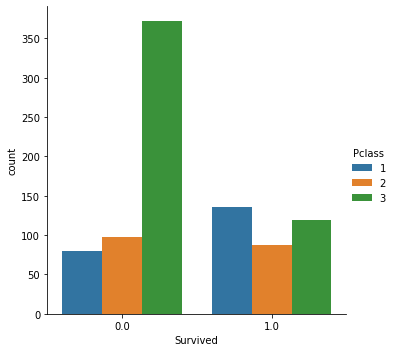

In [8]:
sns.catplot(data = data, x = 'Survived', kind = 'count', 
            hue = 'Pclass')

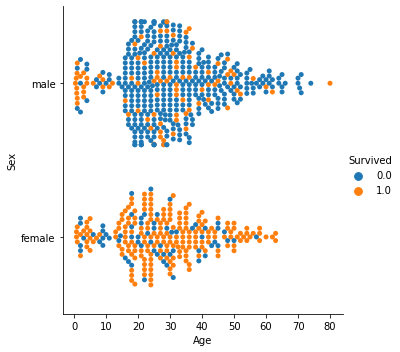

In [9]:
sns.catplot(data = data, x = 'Age', y = 'Sex', kind = 'swarm', 
            hue = 'Survived')

<AxesSubplot:xlabel='Age', ylabel='Count'>

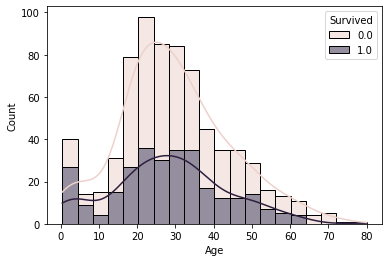

In [10]:
sns.histplot(data = data, x = 'Age', hue = 'Survived', kde = True, multiple = 'stack')

<AxesSubplot:xlabel='Age', ylabel='Count'>

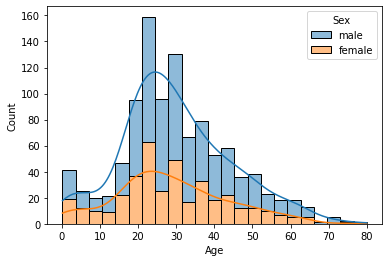

In [11]:
sns.histplot(data = data, x = 'Age', hue = 'Sex', kde = True, multiple = 'stack')

Male children are much more likely to survive compared to male adults -- a fact that can be attributed to the use of life boats. Female children, on the other hand, do not have an increased survival rate when young; females and children borded together.

Females had a much greater survival rate as opposed to men.

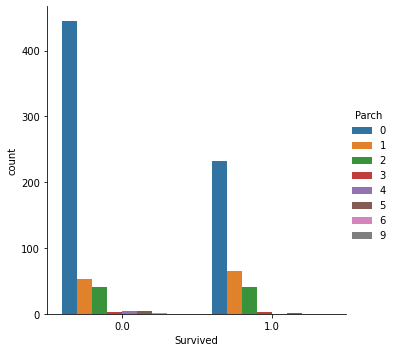

In [12]:
sns.catplot(data = data, x = 'Survived', kind = 'count', 
            hue = 'Parch')

Having a child/parent seems to increase the survival rates -- people may be more motivated to survive if they have a family member on board.

Some of the increase in survival rates can also be attributed to the fact that young children are generally the passengers who would also have their parents on board. Children were the first to board lifeboats and, thus, have a higher survival rate compared to men (Children do seem to have a lower survival rate than women, a fact that may be attributed to their weaker bodies).

There are too few data points to make any conclusions about survival rates of families with large amounts of children.

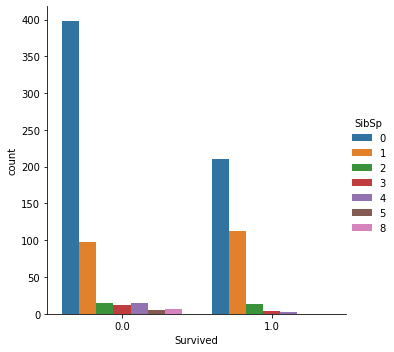

In [13]:
sns.catplot(data = data, x = 'Survived', kind = 'count', 
            hue = 'SibSp')

Similar to having a parent/child on board, passengers with a spouse/sibling are more likely to survive.

MALE


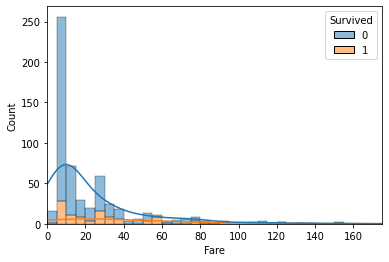

In [14]:
print('MALE')
sns.histplot(data = train[train['Sex'] == 'male'], x = 'Fare', binwidth = 5, hue = 'Survived', kde = True, multiple = 'stack').set_xlim(0,175);

FEMALE


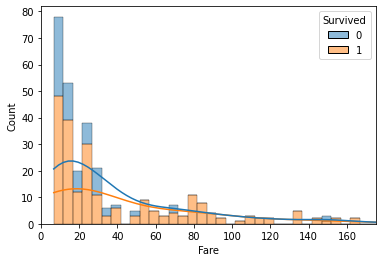

In [15]:
print('FEMALE')
sns.histplot(data = train[train['Sex'] == 'female'], x = 'Fare', binwidth = 5, hue = 'Survived', kde = True, multiple = 'stack').set_xlim(0,175);

Male survivors appear to remain constant through the classes. However, their survival rates do increase as there are less men with high fare prices than low fare prices. Nearly all men with fare prices less than \$25 died.

Female survivors are common at all fare levels. However, at low fares women had a considerable amount of deaths. At the upper end of fare prices there are close to 0 women who died.

In [16]:
print('Survival Rate(Missing Cabin): ', (data[data['Cabin'].isnull()]['Survived'].sum()) / (data[data['Cabin'].isnull()].shape[0]))
print('Survival Rate(W/ Cabin): ', (data[data['Cabin'].notnull()]['Survived'].sum()) / (data[data['Cabin'].notnull()].shape[0]))

Survival Rate(Missing Cabin):  0.20315581854043394
Survival Rate(W/ Cabin):  0.4610169491525424


Simply removing `Cabin` would be a loss in data -- there appears to be a sizable bias in the way `Cabin` features were missing. Instead we will be filling all missing cabins with a seperate category.

\*The bias may be because important people would not have been neglected by the bookeepers. This would mean many of the rich people have their cabin numbers. It is only the less significant people that may have been neglected by book keepers.

In [17]:
data_not_null_cabin = data[data.loc[:,'Cabin'].notnull()].copy().reset_index()
data_not_null_cabin['Cabin'] = data_not_null_cabin['Cabin'].str[:1]

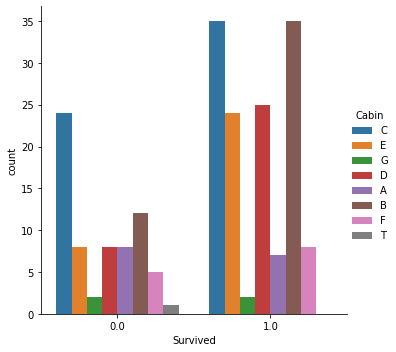

In [18]:
sns.catplot(data = data_not_null_cabin, x = 'Survived', kind = 'count', 
            hue = 'Cabin')

Certain 'Cabin' letters have better survival rates than others. For example, around the same amount of people died from cabin B and cabin C. However, cabin C had more people.

This may be caused by the peoples' proximity to the lifeboats. Levels closer to the top of the boat appear to have higher survival rates.

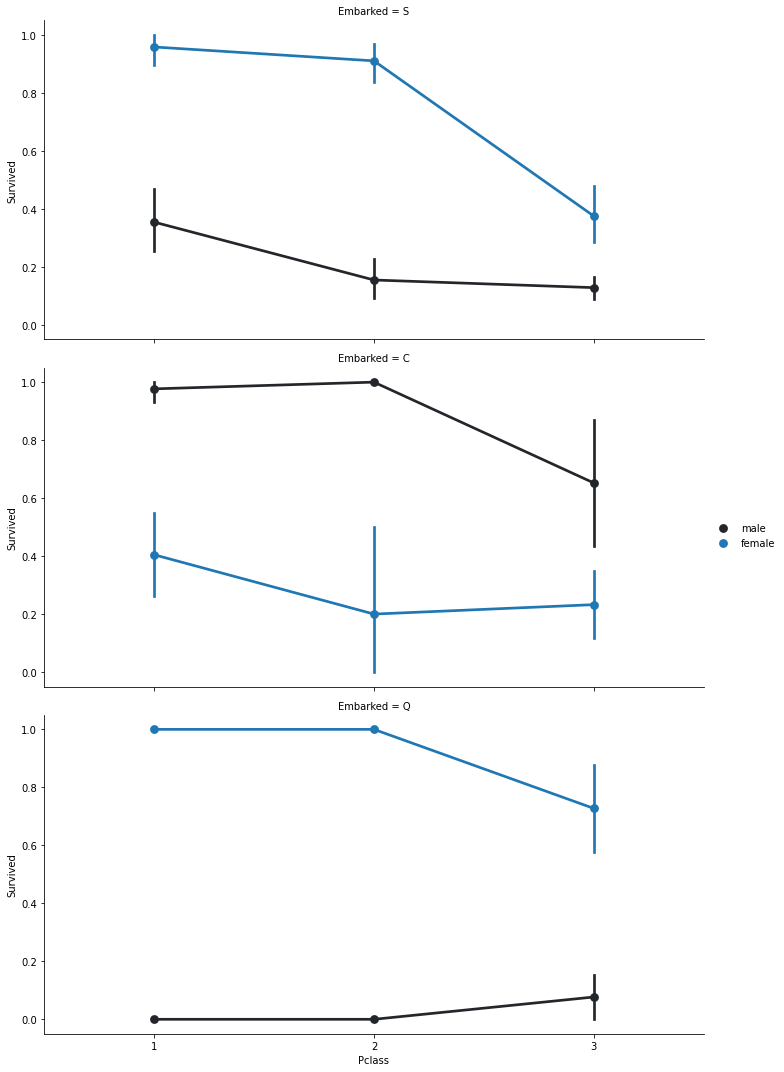

In [19]:
gender_survival_over_embark = sns.FacetGrid(data = data, row = 'Embarked', height = 5, aspect = 2)
gender_survival_over_embark.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', hue_order = None, order = None)
gender_survival_over_embark.add_legend()

Passengers with a specific combination of `Embarked` and `Pclass` seem to have very high survival rates. Some on the other hand had very low survival rates.

Notice how close to no males who embarked from `C` died if they were first or second class. However, first class passengers who embarked at `Q` had close to nill chances of survival.

For females on `Q` on the other hand, nearly no first and second class passengers died.

In [20]:
data['Name'] = data['Name'].str.split('.').str[0].str.split().str[-1]

Your name is not going to save you from death -- people named Jim will not have a lower likelihood of dying from hypothermia. However, the surname may provide additional information not available.

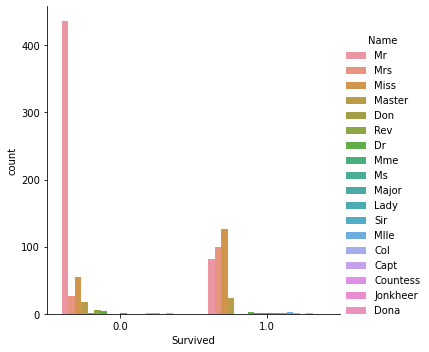

In [21]:
sns.catplot(data = data, x = 'Survived', kind = 'count', 
            hue = 'Name')

Immediatly we can see this graph verify many of our previous observations. Men are very unlikely to survive. Married women (Mrs.) are more likely to survive than not married women (Miss.).

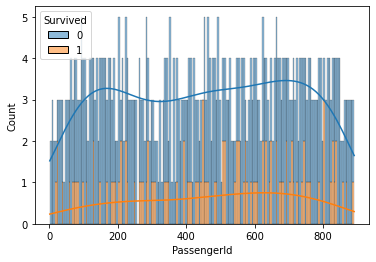

In [22]:
sns.histplot(data = train[train['Sex'] == 'male'], x = 'PassengerId', binwidth = 5, hue = 'Survived', kde = True, multiple = 'stack');

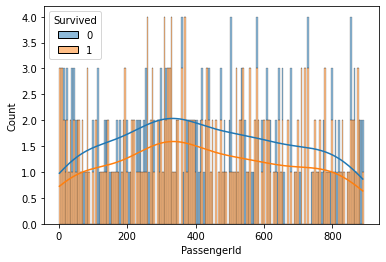

In [23]:
sns.histplot(data = train[train['Sex'] == 'female'], x = 'PassengerId', binwidth = 5, hue = 'Survived', kde = True, multiple = 'stack');

There does not seem to be any significant conclusions that can be drawn. Survival rates for both men and women seem to remain relatively constant -- increases in the survival count also lead to a relative increase in the death count for both genders.

<AxesSubplot:>

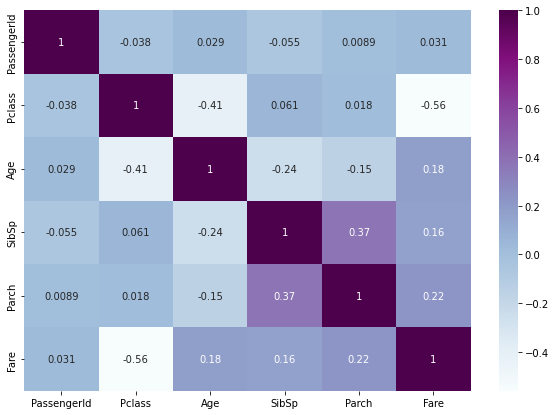

In [24]:
plt.figure(figsize = (10,7))
sns.heatmap(data.drop('Survived',axis = 1).corr(), annot = True, cmap = 'BuPu')

We can see SibSp/Parch share a strong correlation. Because they also share a similar effect on the survival of a passenger, we will be combining these two features into a single feature for travelling with family.

No other features showed a strong correlation with one another.

# **FEATURE ENGINEERING**

We will be filling in missing `Cabin` entries. As discussed earlier we will be creating a new category for all missing Cabin Features.

In [25]:
train['Cabin']= train['Cabin'].replace(np.NaN, 'M')

test['Cabin']= train['Cabin'].replace(np.NaN, 'M')

For `Embarked` we can simply replace the missing values with the mode as there are very few missing points.

In [26]:
train['Embarked'] = train['Embarked'].replace(np.NaN, 'S')

test['Embarked'] = test['Embarked'].replace(np.NaN, 'S')

Similarly, the missing`Fare` value can be replaced by the median.

In [27]:
train['Fare'] = train['Fare'].replace(np.NaN, data['Fare'].median())
test['Fare'] = test['Fare'].replace(np.NaN, data['Fare'].median())

Due to the similarities between `Parch`,`SibSp` and their dependence on one another, we will be combining them into a single feature.

In [28]:
train['Family'] = train['Parch'] + train['SibSp']

test['Family'] = test['Parch'] + test['SibSp']

In [29]:
train['Embarked_Gender'] = train.agg(lambda x: f"{x['Sex']}_{x['Embarked']}", axis=1)
test['Embarked_Gender'] = test.agg(lambda x: f"{x['Sex']}_{x['Embarked']}", axis=1)

Certain combinations of `Sex` and `Embarked` have unusual results -- one example are males who embarked from C.

`Cabin` and `Name` are categorical features with a seperate category for every variable. This is not very useful. Instead, to deal with `Cabin`, we will create categories for every level of the ship. This will allow us to keep the passengers distance from the ship. For `Name` we will simply take extract the title from the `Name`.

In [30]:
train['Name'] = train['Name'].str.split('.').str[0].str.split().str[-1]
train['Cabin'] = train['Cabin'].str[:1]

test['Name'] = test['Name'].str.split('.').str[0].str.split().str[-1]
test['Cabin'] = test['Cabin'].str[:1]

In [31]:
label = 'Survived'
features = ['Pclass', 'Name', 'Sex', 'Family', 'Fare', 'Cabin', 'Embarked_Gender']
train_x = train[features]
train_y = train[label]

These are the features to be used in our model.

**ENCODING AND KNN FOR AGE**

In [32]:
cat = [col for col in train_x.select_dtypes(include = 'object')]
num = [col for col in train_x.select_dtypes(exclude = 'object')]

cat_pipe = Pipeline(steps = [('encode', OrdinalEncoder(handle_unknown = 'use_encoded_value',
                                                      unknown_value = -99))])
num_pipe = Pipeline(steps = [('KNN', KNNImputer(n_neighbors = 5)),
                             ('Standardise', StandardScaler())])

preprocessing = ColumnTransformer(transformers=[("categorical", cat_pipe, cat),
                                                ("numerical", num_pipe, num)])
x_train_prepared = preprocessing.fit_transform(train_x)

# **MODEL**

In [33]:
parameters = [{'C':[.4,.64,.7]},
              {'penalty': ['l1'], 'solver': ['liblinear']},
              {'penalty': ['l2'], 'solver': ['newton-cg','lbfgs']}]
classifier_cv = GridSearchCV(estimator = LogisticRegression(), param_grid = parameters, scoring='roc_auc')

classifier_cv.fit(x_train_prepared, train_y)

print('Tuned hyperparameters: ', classifier_cv.best_params_)

print('Accuracy :', classifier_cv.best_score_)

Tuned hyperparameters:  {'C': 0.4}
Accuracy : 0.8491185073949804


In [34]:
test_prepared = preprocessing.fit_transform(test)
predictions = classifier_cv.predict(test_prepared)
submission = pd.read_csv("../input/titanic/gender_submission.csv")
submission['Survived'] = predictions
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [35]:
submission.to_csv("submission.csv", index=False)